# Simulation Archive
A Simulation Archive (Rein & Tamayo 2017) is useful when one runs long simulations. With the Simulation Archive, one can easily take snapshots of the simulation, and then later restart and analyize it. Since Spring 2018, the default Simulation Archive version is 2. Version 2 works with all integrators and very few restrictions that apply (you need to be careful when using function pointers).

To illustrate the Simulation Archive, let us setup a simulation of a two planet system and turn on the Simulation Archive. This is done with the following code:

In [1]:
import rebound
import numpy as np
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-3, a=1.)
sim.add(m=1e-3, a=1.9)
sim.move_to_com()
sim.dt = sim.particles[1].P*0.05  # timestep is 5% of orbital period
sim.integrator = "whfast"
sim.automateSimulationArchive("archive.bin",interval=1e3,deletefile=True)

The first argument of `automateSimulationArchive` is the path and name of the binary file to write to, the `interval` argument specifies the interval at which snapshots of the simulation are saved (in whichever code units you work). The smaller the interval, the larger the file size, but the faster the access. The `deletefile=True` flag makes REBOUND delete the file if it already exists.

We now integrate the simulation forward in time. This should take a few seconds.

In [2]:
sim.integrate(1e6)

We can now delete the simulation. Note that we could also have run the simulation using the C version of REBOUND. This might be useful if one wants to run a long simulation on a cluster and doesn't want to bother with installing python. In C, one can initialize the Simulation Archive with (you need to delete the file manually if it already exists):
```c
struct reb_simulation* sim = reb_create_simulation();
...
reb_simulationarchive_automate_interval("archive.bin",1e3);
```

In [3]:
del sim

We now look at the Simulation Archive. You could do this at a later time, on a different computer, with a different version of REBOUND and it will still work. 

In [4]:
sa = rebound.SimulationArchive("archive.bin")

Let's first print the number of snapshots and the time of the first and last snaphot in the archive:

In [5]:
print("Number of snapshots: %d" % len(sa))
print("Time of first and last snapshot: %.1f, %.1f" % (sa.tmin, sa.tmax))

Number of snapshots: 1001
Time of first and last snapshot: 0.0, 1000000.0


We can access each snapshot by indexing the Simulation Archive. This returns a REBOUND simulation object that corresponds to that time. Everything is accurate down to the last bit. That means one could use this simulation object and restart the simulation, the final coordinates of the planets will be exactly the same as in the original simulation.

In [6]:
sim = sa[500]
print(sim.t, sim.particles[1])

500000.311856871 <rebound.Particle object, m=0.001 x=0.9504733687298914 y=-0.31369991066301284 z=0.0 vx=0.3120007981838394 vy=0.9470716927681876 vz=0.0>


One can also step through every simulation in the archive using the generator functionality, for example to store the eccentricity of the inner planet as a function of time:

In [7]:
eccentricities = np.zeros(len(sa))
for i, sim in enumerate(sa):
    eccentricities[i] = sim.particles[1].e

If we want to access a simulation at a specific time, such as in-between snapshots, one can use the `getSimulation()` function:

In [8]:
sim = sa.getSimulation(12345.6)
print(sim.t)

12000.226030496653


By default, the function returns a simulation that corresponds to the snapshot that is nearby. To get closer to the requested time, one can use the `mode` attribute:

In [9]:
sim = sa.getSimulation(12345.6, mode="close")
print(sim.t)

12345.628564279925


In the above code, REBOUND looks up a nearby snaphot and then integrates the simulation forward in time to get close to the request time. As one can see, with `mode="close"`, one gets a simulation very close to the request time, but it is still slightly off. This is because `WHFast` uses a fixed timestep. If we want to reach the requested time eactly, we have to change the timestep. Changing a timestep in a symplectic integrator can cause problems, but if one really wants to get a simulation object at the exact time (for example to match observations), then the `mode="exact"` flag does that.

In [10]:
sim = sa.getSimulation(12345.6, mode="exact")
print(sim.t)

12345.6


Requesting a simulation at any time between `tmin` and `tmax` only takes a few seconds at most (keep in mind, REBOUND integrates the simulation from the nearest snaphot to the requested time). To analyze a large simulation, you might want to do this in parallel. We can easily do that by using REBOUND's `InterruptiblePool`. In the following example, we calculate the distance between the two planets at 432 times in the interval $[t_{min},t_{max}]$.

In [11]:
def thread_init(*rest):
    global sat
    sat = rebound.SimulationArchive("archive.bin")
def analyze(t):
    sim = sat.getSimulation(t,mode="close")
    d12 = sim.particles[1] - sim.particles[2]
    return np.sqrt(d12.x*d12.x+d12.y*d12.y+d12.z*d12.z)
pool = rebound.InterruptiblePool(initializer=thread_init)
times = np.linspace(sa.tmin, sa.tmax, 432)
distances = pool.map(analyze,times)

Note that in the above example, we use an initializer function so that each thread has its own Simulation Archive.

# Note

Since Spring 2018, the `SimulationArchive` object always returns a new `Simulation` object when you request a simulation from the archive. In earlier versions, it kept a reference to one `Simulation` object internally, updated it when a new time was requested, and then returned a reference.

# Manual Snapshots

With the new version of the simulation archive you can also add snapshots manually, giving you further control beyond the automated options used above. This can be useful to save snapshots when particular conditions like collisions or ejections occur. Here we give an example that saves logarithmically spaced snapshots

In [12]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-3, a=1.)
sim.add(m=1e-3, a=1.9)
sim.move_to_com()
sim.dt = sim.particles[1].P*0.05  # timestep is 5% of orbital period
sim.integrator = "whfast"

We now iterate over an array of logarithmically spaced times, and save a snapshot after each using the manual `simulationarchive_snapshot` function. If no file with that filename exists, it will create a new one first. Note that if it doesn't already exist, it will always *append* a snapshot to the file, so you need to delete any existing file when starting a new simulation.

In [13]:
filename = 'testsa.bin'

Nout = 1000
times = np.logspace(0, 4, Nout)*sim.particles[1].P
for i, time in enumerate(times):
    sim.integrate(time, exact_finish_time=0) # need outputs on the nearest WHFast timesteps to the times we pass to get symplectic behavior
    sim.simulationarchive_snapshot(filename)

We now plot the energy error at each of the snapshots

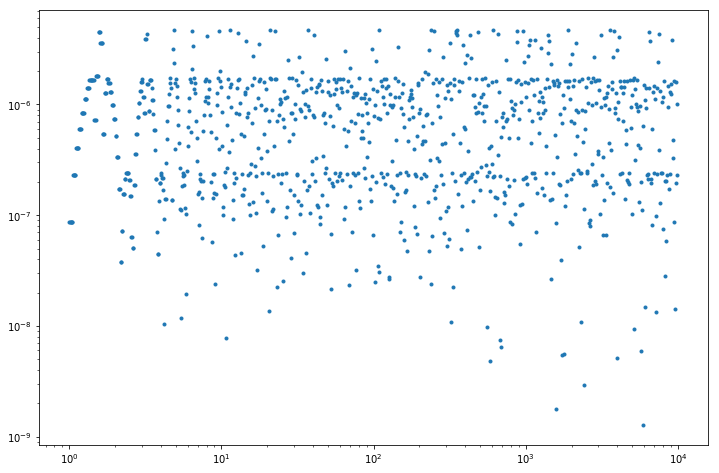

In [14]:
sa = rebound.SimulationArchive(filename)
sim0 = sa[0]
P = sim0.particles[1].P
E0 = sim.calculate_energy()

Eerr = np.zeros(Nout)
for i, sim in enumerate(sa):
    E = sim.calculate_energy()
    Eerr[i] = np.abs((E-E0)/E0)

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times/sim0.particles[1].P, Eerr, '.')
ax.set_xscale('log')
ax.set_yscale('log')

One can also add manual snapshots when using automated intervals.